### Time series + EMA

Discover users who are accessing our curriculum pages way beyond the end of their codeup time.  What would the dataframe look like?  Use time series method for detecting anomalies, like exponential moving average with %b. 


To measure anomalies for each cohort in number of page views per day:
2. group by day, cohort_id, aggregate page_viewed using count
3. compute EMA by cohort, 7 days, UB and LB
4. compute %b for each user

In [66]:
from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from random import randint
from matplotlib import style
import seaborn as sns
%matplotlib inline

### Wrangle Data

In [67]:
colnames=['date','page_viewed','user_id','cohort_id','ip']
df = pd.read_csv('anonymized-curriculum-access.txt',          
                 engine='python',
                 header=None,
                 index_col=False,
                 names=colnames,
                 sep=r'\s(?=(?:[^"]*"[^"]*")*[^"]*$)(?![^\[]*\])',
                 na_values='"-"',
                 usecols=[0,2,3,4,5]
)

In [68]:
df = df.dropna()
df.cohort_id = df.cohort_id.astype('int')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 219070 entries, 0 to 233527
Data columns (total 5 columns):
date           219070 non-null object
page_viewed    219070 non-null object
user_id        219070 non-null int64
cohort_id      219070 non-null int64
ip             219070 non-null object
dtypes: int64(2), object(3)
memory usage: 10.0+ MB
None


,date,page_viewed,user_id,cohort_id,ip
0,2018-01-26,/,1,8,97.105.19.61
1,2018-01-26,java-ii,1,8,97.105.19.61
2,2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61
3,2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61
4,2018-01-26,javascript-i/conditionals,2,22,97.105.19.61


In [69]:
colnames=['cohort_name','cohort_id']
df_cohort = pd.read_csv('cohort_id_name.csv',
                       names=colnames, 
                       skiprows=1)
print(df_cohort.info())
df_cohort.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
cohort_name    31 non-null object
cohort_id      31 non-null int64
dtypes: int64(1), object(1)
memory usage: 576.0+ bytes
None


,cohort_name,cohort_id
0,Arches,1
1,Badlands,2
2,Carlsbad,3
3,Denali,4
4,Everglades,5


In [70]:
df = df.merge(df_cohort, on='cohort_id', how='left')
df.head()

,date,page_viewed,user_id,cohort_id,ip,cohort_name
0,2018-01-26,/,1,8,97.105.19.61,Hampton
1,2018-01-26,java-ii,1,8,97.105.19.61,Hampton
2,2018-01-26,java-ii/object-oriented-programming,1,8,97.105.19.61,Hampton
3,2018-01-26,slides/object_oriented_programming,1,8,97.105.19.61,Hampton
4,2018-01-26,javascript-i/conditionals,2,22,97.105.19.61,Teddy


In [71]:
df['date'] = pd.to_datetime(df.date)
df = df.dropna()

In [72]:
df_agg = df.groupby(['date','cohort_id','cohort_name'])['user_id'].\
                        nunique().\
                    reset_index().\
                    rename(index=str, 
                       columns={'user_id': 'users_viewed'})

In [73]:
df_agg.head()

,date,cohort_id,cohort_name,users_viewed
0,2018-01-26,1,Arches,1
1,2018-01-26,8,Hampton,1
2,2018-01-26,13,Kings,1
3,2018-01-26,16,Niagara,2
4,2018-01-26,18,Pinnacles,1


### EMA

In [74]:
cohorts = list(df_agg.cohort_name.unique())
cohorts

['Arches',
 'Hampton',
 'Kings',
 'Niagara',
 'Pinnacles',
 'Quincy',
 'Sequoia',
 'Teddy',
 'Lassen',
 'Mammoth',
 'Glacier',
 'Denali',
 'Joshua',
 'Olympic',
 'Ulysses',
 'Badlands',
 'Apollo',
 'Ike',
 'Voyageurs',
 'Wrangell',
 'Xanadu',
 'Franklin',
 'Yosemite',
 'Staff',
 'Zion',
 'Andromeda']

In [75]:
df_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3366 entries, 0 to 3365
Data columns (total 4 columns):
date            3366 non-null datetime64[ns]
cohort_id       3366 non-null int64
cohort_name     3366 non-null object
users_viewed    3366 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 131.5+ KB


In [87]:
df = df_agg.set_index('date').\
            rename(index=str, columns={'users_viewed':'ema'}).\
            drop(columns='cohort_id')


In [90]:
def bollinger_bands(df):
    ema = df.ewm(span=14, adjust=False).mean()
    ema['stdev'] = ema.ema.rolling(14).std()
    ema['ub'] = ema.ema + ema.stdev*3
    ema['lb'] = ema.ema - ema.stdev*3
    return ema.reset_index()

In [91]:
# bollinger_bands(df_agg[df_agg.cohort_id==8])
bands = []
for cohort in cohorts:
    bb = bollinger_bands(df[df.cohort_name == cohort])
    bands.append(bb)

df2 = pd.concat(bands)

In [97]:
df2.head()

,date,cohort_name,ema,stdev,ub,lb
0,2018-01-26 00:00:00,Arches,1.000000,NaN,NaN,NaN
1,2018-01-29 00:00:00,Arches,1.500000,NaN,NaN,NaN
2,2018-01-30 00:00:00,Arches,1.625000,NaN,NaN,NaN
3,2018-01-31 00:00:00,Arches,1.718750,NaN,NaN,NaN
4,2018-02-01 00:00:00,Arches,1.539062,NaN,NaN,NaN


In [94]:
df2.isnull().sum()

date             0
cohort_name      0
ema              0
stdev          146
ub             146
lb             146
dtype: int64

In [98]:
df_missing = df2[df2.stdev.isnull()][['cohort_name','ema']]
df_missing.head()

,cohort_name,ema
0,Arches,1.000000
1,Arches,1.500000
2,Arches,1.625000
3,Arches,1.718750
4,Arches,1.539062


In [99]:
df_missing = df_missing.groupby('cohort_name').std().fillna(value=0).reset_index().rename(index=str, columns={'ema': 'stdev_null'})
df_missing.head()

,cohort_name,stdev_null
0,Andromeda,4.222773
1,Apollo,0.000000
2,Arches,0.251638
3,Badlands,0.000000
4,Denali,0.000000


In [100]:
df = df2.merge(df_missing, on='cohort_name', how='left')

In [101]:
df.head()

,date,cohort_name,ema,stdev,ub,lb,stdev_null
0,2018-01-26 00:00:00,Arches,1.000000,NaN,NaN,NaN,0.251638
1,2018-01-29 00:00:00,Arches,1.500000,NaN,NaN,NaN,0.251638
2,2018-01-30 00:00:00,Arches,1.625000,NaN,NaN,NaN,0.251638
3,2018-01-31 00:00:00,Arches,1.718750,NaN,NaN,NaN,0.251638
4,2018-02-01 00:00:00,Arches,1.539062,NaN,NaN,NaN,0.251638


In [102]:
idx = df.stdev.isnull()
df.loc[idx,'stdev'] = df.loc[idx,'stdev_null']
df = df.drop(columns='stdev_null')
df.head()

,date,cohort_name,ema,stdev,ub,lb
0,2018-01-26 00:00:00,Arches,1.000000,0.251638,NaN,NaN
1,2018-01-29 00:00:00,Arches,1.500000,0.251638,NaN,NaN
2,2018-01-30 00:00:00,Arches,1.625000,0.251638,NaN,NaN
3,2018-01-31 00:00:00,Arches,1.718750,0.251638,NaN,NaN
4,2018-02-01 00:00:00,Arches,1.539062,0.251638,NaN,NaN


In [103]:
idx = df.ub.isnull()
df.loc[idx,'ub'] = df.loc[idx,'ema'] + df.loc[idx,'stdev']*3
df.loc[idx,'lb'] = df.loc[idx,'ema'] - df.loc[idx,'stdev']*3
df.head()

,date,cohort_name,ema,stdev,ub,lb
0,2018-01-26 00:00:00,Arches,1.000000,0.251638,1.754913,0.245087
1,2018-01-29 00:00:00,Arches,1.500000,0.251638,2.254913,0.745087
2,2018-01-30 00:00:00,Arches,1.625000,0.251638,2.379913,0.870087
3,2018-01-31 00:00:00,Arches,1.718750,0.251638,2.473663,0.963837
4,2018-02-01 00:00:00,Arches,1.539062,0.251638,2.293976,0.784149


In [109]:
idx = df.ub == df.lb
df.loc[idx,'ub'] = df.loc[idx,'ub'] + .01
df.loc[idx,'lb'] = df.loc[idx,'lb'] - .01

In [113]:
df.date = pd.to_datetime(df.date)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 6 columns):
date           3366 non-null datetime64[ns]
cohort_name    3366 non-null object
ema            3366 non-null float64
stdev          3366 non-null float64
ub             3366 non-null float64
lb             3366 non-null float64
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 184.1+ KB


In [112]:
df_agg.info()


<class 'pandas.core.frame.DataFrame'>
Index: 3366 entries, 0 to 3365
Data columns (total 4 columns):
date            3366 non-null datetime64[ns]
cohort_id       3366 non-null int64
cohort_name     3366 non-null object
users_viewed    3366 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 131.5+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3366 entries, 0 to 3365
Data columns (total 6 columns):
date           3366 non-null object
cohort_name    3366 non-null object
ema            3366 non-null float64
stdev          3366 non-null float64
ub             3366 non-null float64
lb             3366 non-null float64
dtypes: float64(4), object(2)
memory usage: 184.1+ KB


In [114]:
# join with aggregated dataset to get the original count of users viewed
df = df.merge(df_agg, on=['cohort_name','date'], how='left')

In [115]:
df.head()

,date,cohort_name,ema,stdev,ub,lb,cohort_id,users_viewed
0,2018-01-26,Arches,1.000000,0.251638,1.754913,0.245087,1,1
1,2018-01-29,Arches,1.500000,0.251638,2.254913,0.745087,1,3
2,2018-01-30,Arches,1.625000,0.251638,2.379913,0.870087,1,2
3,2018-01-31,Arches,1.718750,0.251638,2.473663,0.963837,1,2
4,2018-02-01,Arches,1.539062,0.251638,2.293976,0.784149,1,1


In [116]:
# compute %b
df['pct_b'] = (df.users_viewed-df.lb)/(df.ub-df.lb)
df = df.drop(columns=['stdev','cohort_id'])
df.head()

,date,cohort_name,ema,ub,lb,users_viewed,pct_b
0,2018-01-26,Arches,1.000000,1.754913,0.245087,1,0.500000
1,2018-01-29,Arches,1.500000,2.254913,0.745087,3,1.493492
2,2018-01-30,Arches,1.625000,2.379913,0.870087,2,0.748373
3,2018-01-31,Arches,1.718750,2.473663,0.963837,2,0.686280
4,2018-02-01,Arches,1.539062,2.293976,0.784149,1,0.142964


In [117]:
df[df.pct_b>1].sort_values(by='pct_b', ascending=False)

,date,cohort_name,ema,ub,lb,users_viewed,pct_b
112,2018-06-11,Arches,2.284321,2.809431,1.759211,4,2.133638
2359,2019-02-24,Ulysses,1.999196,2.647213,1.351180,4,2.043791
1428,2018-07-24,Teddy,2.833111,4.201784,1.464439,7,2.022238
1617,2018-03-26,Lassen,1.662920,2.111319,1.214522,3,1.990951
2286,2018-11-05,Ulysses,2.234703,3.164403,1.305003,5,1.987199
1672,2018-06-04,Lassen,1.274565,1.524832,1.024297,2,1.949320
1240,2019-02-21,Sequoia,1.276173,1.526228,1.026119,2,1.947336
835,2018-07-09,Pinnacles,1.276388,1.526434,1.026342,2,1.946958
668,2018-05-06,Niagara,1.276490,1.526533,1.026447,2,1.946769
696,2018-08-13,Niagara,1.269193,1.522033,1.016354,2,1.945198


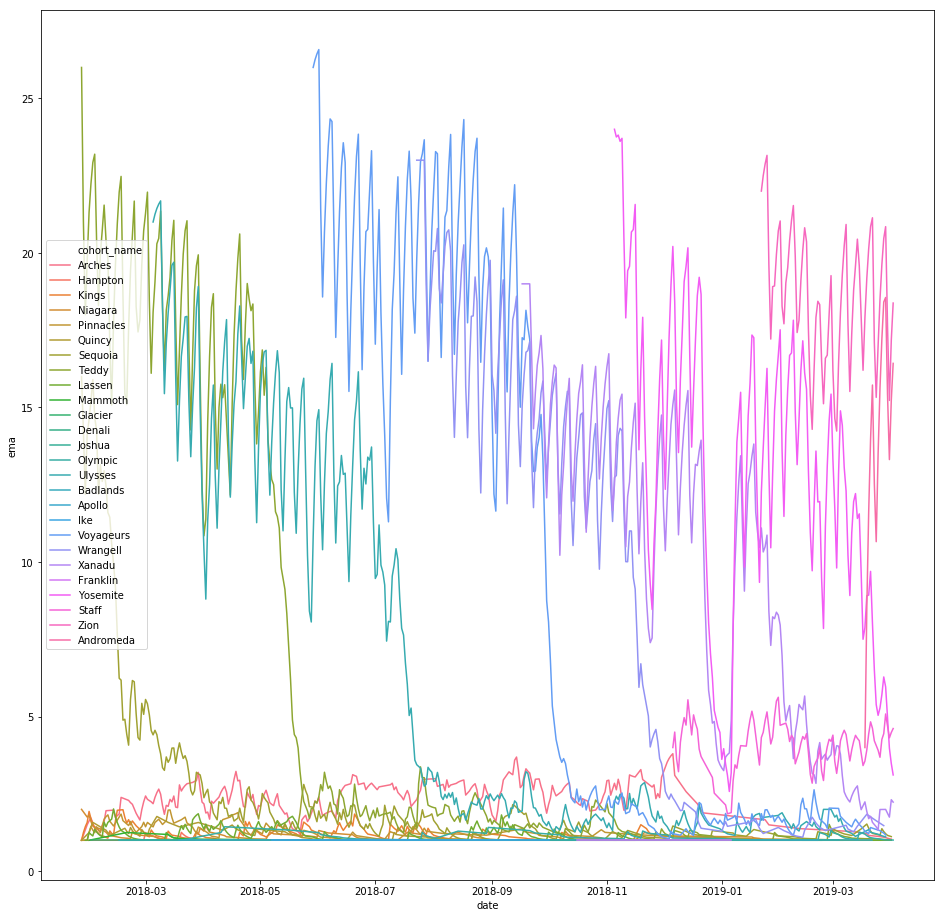

In [118]:
# plot the 7 day exponential moving average
fig = plt.figure(figsize=(16,16))
sns.lineplot(df.date, df.ema, hue=df.cohort_name)